<a href="https://colab.research.google.com/github/Bensmail-anis/Autoregressive-Character-Level-Language-Modeling/blob/main/notebooks/Backpropagation_Under_the_Hood_Hardcoding_and_Gradient_Calculation_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Backpropagation under the hood :

**In this notebook , there is a draft section to help me calculate the derivatives and backpropagations and math stuff -- you can avoid it**


In the previous notebooks, we manually implemented the essential neural network classes for our character-level language model. This included creating the necessary layers classes , defining neurons with Kaiming initialization, and incorporating batch normalization with its various parameters. These steps provided us with a solid understanding of how neural networks function.


Our implementation was similar to the MLP language model proposed by Bengio et al. in 2003, but we applied it at the character level.

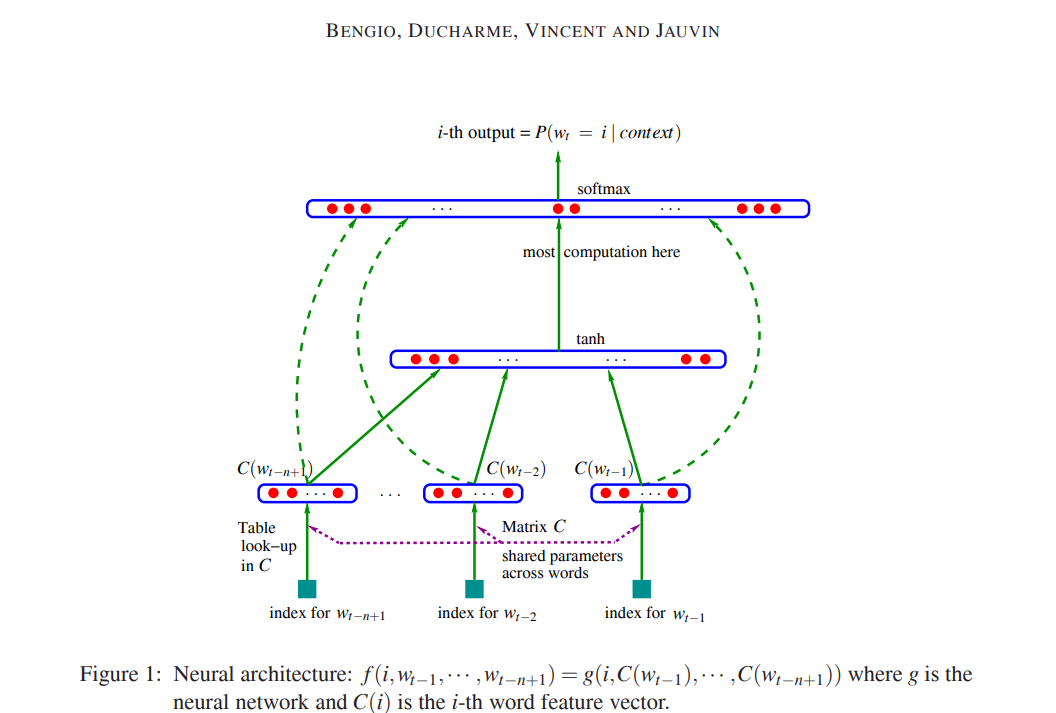

However, one key operation—"loss.backward()"—was handled by PyTorch's built-in class, which concealed the inner workings of backpropagation. In this notebook, we aim to manually implement the backward pass to gain a deeper understanding of the propagation process

We will keep the same code we introduced last time to prepare data

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [ ]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [ ]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [ ]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


We will build a function to compare later our gradient calculated manually with the pytorch claculated gradient

In [ ]:
def cmp(s, dt, t):
  ex = torch.all(dt == t.grad).item() # torch.all(...) Checks if all elements in the boolean tensor are True , .item(): Converts the resulting single-element tensor to a Python scalar (True or False).
  app = torch.allclose(dt, t.grad) # Checks whether dt and t.grad are approximately equal, considering small numerical differences.This method allows for small tolerances, making it useful when dealing with floating-point precision issues.
  maxdiff = (dt - t.grad).abs().max().item()
  print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

We initialize the layers using Kaiming initialization. For educational purposes, we will use 𝑏1 this time, even though it's redundant due to the presence of a bias parameter in batch normalization.

In [ ]:
n_embd = 10
n_hidden = 64

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
#Layer1
w1 = torch.randn((n_embd * block_size, n_hidden),generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1

#Layer2
w2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1 # remember that making the weights near 0 is likely starting the prediction with a uniform distribution for all the classes which is good rather than starting with magical numbers and big loss
b2 = torch.randn(vocab_size,                      generator=g) * 0.1

#Batchnirm params
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1


parameters = [C, w1, b1, w2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

4137


In [ ]:
batch_size = 32
n = batch_size # a shorter variable also, for convenience
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g) # Xtr.shape[0]: The highest index (exclusive), representing the total number of samples in Xtr
Xb , Yb = Xtr[ix] , Ytr[ix] # batch X,Y ,Xtr[ix]: Selects batch_size (32) random samples from Xtr based on the indices ix. Ytr[ix]: Selects the corresponding labels from Ytr.

We will implement now the forward in mini steps so we will able to propagate manually later

In [ ]:
# forward pass

emb = C[Xb] # embed the characters into vectors from the C matrix and using Xb as indices
embcat = emb.view(emb.shape[0], -1) # concatenate the vectors , we have 32 samples of 3 charcters , each one has 10 d embeddings , we will conctenate the 3 characters embeddings together to get 32 * 30

In [ ]:
embcat.shape

torch.Size([32, 30])

In [ ]:
#Layer1
hprebn = embcat @ w1 + b1 # hidden layer pre-activation
bnmeani = 1/n*hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1) * bndiff2.sum(0, keepdim=True) # variance ,  be nice and use bessel's correction (divide by (n-1) not n)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias # Batch normalization params
# Non linearity
h = torch.tanh(hpreact) # hidden layer

#Layer2
logits = h @ w2 + b2 # output layer

# Cross entropy loss (same as F.cross_entropy)
logit_maxes = logits.max(1, keepdim=True).values # we keep keepdim = True to avoid broadcasting prblms later when we use the output in the next operations , we find the max for each line of logits so logit_maxes is of shape (32,1)
norm_logits = logits - logit_maxes # subtract max for numerical stability , since we will use exp so not to want end up with magical values
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True) # like the shape of counts_sum is (32,1) now since it will contains the sum of each line of counts_sum and by keeping the 2 dimensions by the param keepdim to not get broadcasting errors later
counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()  # negative log likelhood as loss




In [ ]:
# Pytorch backward pass

for p in parameters :
  p.grad = None # None for efficiency
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, norm_logits , logit_maxes , logits , h , hpreact , bnraw , bnvar_inv , bnvar , bndiff2 , bndiff , hprebn , bnmeani,embcat , emb]:
  t.retain_grad() # to keep the grad calculated so we can compare it later
loss.backward()
loss

tensor(3.3377, grad_fn=<NegBackward0>)

## backprop through the whole thing manually :
- we pay attention to the tensors shapes "where there is broadcasting -imagine the replication accross the samples to get it clear"
- chain rule
- Remember that * is not @
- Try to find any formula of matrices

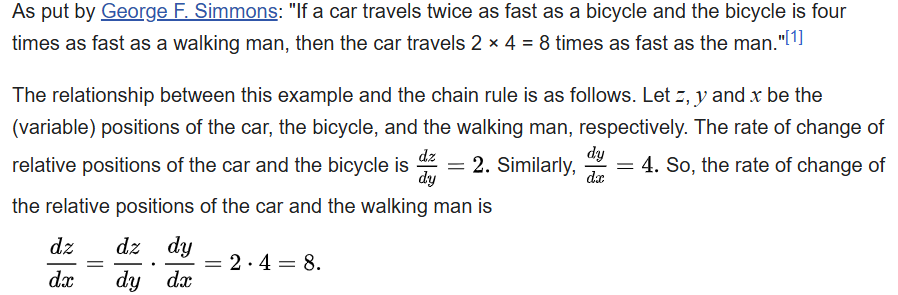

# Draft section

**This part is just like a draft paper**
You will find the final calculations after it

--------------------------------------------------------------------------------

to help us calculate dlogprobs/dprobs :

In [ ]:
logprobs.shape ,probs.shape #here no prblm with shapes to calculate dlogprobs/dprobs

(torch.Size([32, 27]), torch.Size([32, 27]))

to help us calculate dprobs/dcounts_sum_inv :

In [ ]:
counts_sum_inv.shape , counts.shape , (counts*counts_sum_inv).shape # to calculate dprobs/dcounts_sum_inv to use it later in chain rule , when we multiply those we find that there is replicated b across each row as below :

(torch.Size([32, 1]), torch.Size([32, 27]), torch.Size([32, 27]))

In [ ]:
#c = a * b with tensors :
# a[3*3] * b[3*1]
# a11*b1 a12b1 a13b1
# a21*b2 a22b2 a23b2
# a31*b3 a32b3 a33b3
# c[3*3]



to help us calculate dcounts_sum/dcounts :

In [ ]:
counts.shape , counts_sum.shape

(torch.Size([32, 27]), torch.Size([32, 1]))

In [ ]:
# counts_sum = counts.sum(1, keepdims=True)
# a11 a12 a13 --> b1 = a11 +a12+ a13
# a21 a22 a23 --> b2 = a21 +a22 +a23
# a31 a32 a33 --> b3 = a31 +a32+ a33

# the effects of counts elements are equally each line to get counts_sum , we can express that by dcounts_sum/dcounts = torch.ones_like(counts)

to help us calculate dnorm_logits/dlogit_maxes :

In [ ]:
norm_logits.shape ,logits.shape, logit_maxes.shape # clearly we are dealing with the same situation before , logit_maxes has one value per row , we want to obtain the effect of this value , this is by sum of all the norm_logits values that will be multiplied to that logit_maxes value replicated

(torch.Size([32, 27]), torch.Size([32, 27]), torch.Size([32, 1]))

In [ ]:
# c11 c12 c13 = a11 a12 a13    b1
# c21 c22 c23 = a21 a22 a23 -  b2
# c31 c32 c33 = a31 a32 a33    b3

# no direct effect here , but we maintain (-) in dlogit_maxes = (dnorm_logits*(-1)).sum(1 , keepdim=True)

to help us calculating dnorm_logits/dlogits:

In [ ]:
# Since logits.max() is necessary ot calculate dlogit_maxes which is a part of dnorm_logits , we want to calculate dlogit_maxes/dlogits ,  we need to get the dlogit_maxes and scatter it to the correct positions of logits "the positions we took the max"
# so we will have :
F.one_hot(logits.max(1).indices,num_classes=logits.shape[1])

tensor([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
         0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
         0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0],


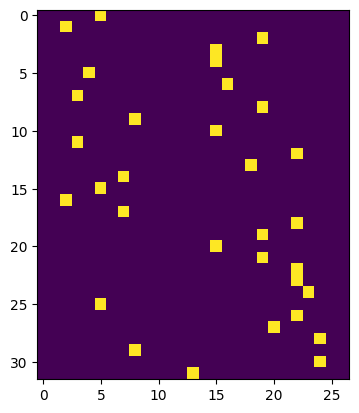

In [ ]:
plt.imshow(F.one_hot(logits.max(1).indices,num_classes=logits.shape[1]))

In [ ]:
#pay attention that :
logit_maxes.shape , logits.shape

# so when we muliply them you will think we must add .sum(1 , keepdim=True ) , as usual , but it is equivalent to multiply logit_maxes.shape to F.one_hot(logits.max(1).indices,num_classes=logits.shape[1]) since it is one encoding , like one value per raw , so the sum itself

(torch.Size([32, 1]), torch.Size([32, 27]))

to help us calculate dloss/dh :

In [ ]:
h.shape , w2.shape , dlogits.shape , b2.shape # the addition of b2 through braodcasting , we got logits by @ "matrix multiplication sign"
#remember broadcasting rule , we make it to the full right "27 being at right " , then we duplicate all the values , b2 vector will be repeated by each row "32 times in our case"

(torch.Size([32, 64]),
 torch.Size([64, 27]),
 torch.Size([32, 27]),
 torch.Size([27]))

let us get it by hands through a simple example to get the pattern of a :

logits = h @ w2 +b2

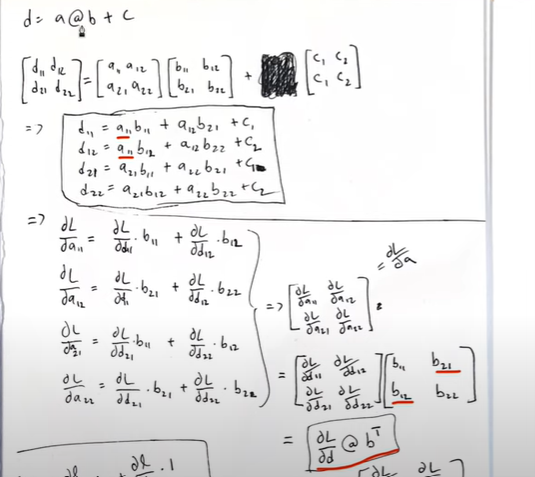

so dloss/dh is the same as dlogits @ w2 transposed

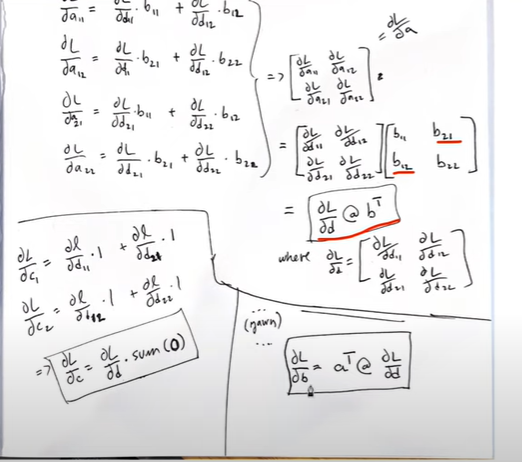

and for dloss/w2 , we can prouve that is dw2 = h transposed @ dlogits

dloss/db2 = dlogits.sum(0)

Even though , lets play it without math:

when calculating dh , it must have the same shape of h , the only way of that is indeed : dlogits with the shape of torch.Size([32, 27]) multiplied by the transposed of w2 than become (27 , 64) of shape , so we will have a shape of (32 , 64)

The same intuition with dw2 , and db2 where b2 is a vector "value per row " , as we did before it will have the sum of the contribution of this value into logits , that gives us dlogits.sum(0)"this time is across the columns "the way b2 values are replicated " -- you can imagine it that each value of b2 is repeated across the columns to get logits after the broadcasting

--as you can imagine it too , logits has shape of torch.Size([32, 27]), and b2 of torch.Size([27])) , so the sum will be across the axe 0 to eliminate the dim 0 of logits

to help us calculate dbnbias , dbnraw , dbngain :

In [ ]:
bnbias.shape , bnraw.shape , bngain.shape , hpreact.shape # and we have hpreact = bngain * bnraw + bnbias , so another broadcasting here

(torch.Size([1, 64]),
 torch.Size([32, 64]),
 torch.Size([1, 64]),
 torch.Size([32, 64]))

dloss/dbngain :

In [ ]:
# to find .sum(0) or .sum(1) , look to the axe we eliminate of the matrix which we will multiply

In [ ]:
# bngain * bnraw  , torch.Size([1, 64] * torch.Size([32, 64]) so we eliminate the first axe so .sum(0) , you can even imagine the broadcasting and contribution of dbngain , axe 0 is the direction of replication , imagine logically

In [ ]:
# any value of bngain will be replicated across the raws of bnraw , like a row of bngain , each value of it will be replicated across the axe 0 , not the case before when we have (27,1) replicated over (27,30)

In [ ]:
# In gnrl , pay atttention to the number of samples of the batch too , do the same approach with  dbnbias

dloss/dbnraw

In [ ]:
# it will have the same shape of dbraw (32 ,64) , we focus on the effects of these values so we multiply dbgain easily with hpreact , no broadcasting prblms

To help us calculate dloss/ddbnvar_inv

In [ ]:
bnraw.shape,bndiff.shape ,bnvar_inv.shape   #bnraw = bndiff * bnvar_inv , the same braodcasting and replication issue , we elimnate th first axes of 0

(torch.Size([32, 64]), torch.Size([32, 64]), torch.Size([1, 64]))

To help us calculate dloss/dbnvar

In [ ]:
#bnvar_inv = (bnvar + 1e-5)**-0.5
bnvar_inv.shape , bnvar.shape

(torch.Size([1, 64]), torch.Size([1, 64]))

to help us calculate dloss/dbndiff2

In [ ]:
bnvar.shape , bndiff2.shape

(torch.Size([1, 64]), torch.Size([32, 64]))

to help us calculate dbndiff2/dbndiff

In [ ]:
bndiff2.shape , bndiff.shape , bnraw.shape  ,bnvar_inv.shape

(torch.Size([32, 64]),
 torch.Size([32, 64]),
 torch.Size([32, 64]),
 torch.Size([1, 64]))

dloss/dbnmeani , dloss/ddhprebn

In [ ]:
bnmeani.shape , bndiff.shape , hprebn.shape

(torch.Size([1, 64]), torch.Size([32, 64]), torch.Size([32, 64]))

lets calculate dembcat , dw1 , db1

In [ ]:
# hprebn = embcat @ w1 + b1
hprebn.shape , embcat.shape , w1.shape , b1.shape # we can use the math things we did before , but i want to use intuition , dembcat should be the same size as enbcat so the only way is hprebn @ w1.T and so on , for b1 , we eliminate the first axe of hprebn

(torch.Size([32, 64]),
 torch.Size([32, 30]),
 torch.Size([30, 64]),
 torch.Size([64]))

dloss/demb

In [ ]:
# embcat = emb.view(emb.shape[0], -1)
emb.shape , embcat.shape

(torch.Size([32, 3, 10]), torch.Size([32, 30]))

In [ ]:
# demb must have the same shape as emb , we have already dembcat , and embcat as just a reformulation of emb , we do the same to get demb
# demb = dembcat.view(emb.shape)

dC

In [ ]:
# emb = C[Xb] , We need to find  which row of c we got the elements of emb , how C influence emb , so we must undo the indexing from emb to C , if any row of C it is used many times we have to sum its gradients
emb.shape , C.shape , Xb.shape

(torch.Size([32, 3, 10]), torch.Size([27, 10]), torch.Size([32, 3]))

In [ ]:
# dC = torch.zeros_like(C) # dC must have the same shape of C , we start by initializing by 0 , than we sum the contributions for each element
# for k in range(Xb.shape[0]):
#     for j in range(Xb.shape[1]):
#         ix = Xb[k,j] # this must surely give the line of embeddings we need from C , so this line will contribute
#         dC[ix] += demb[k,j] # we take only the first 2 dim from emb , from the start the operation is only emb = C[Xb] , C[ix] will receive the derivative of emb[k,j] like the contribution of those elements contains the whole line of C , many letters can be replicated much so we put C[ix] += ...

--------------------------------------------------------------------------------

# Implementing the calculations

In [ ]:
# backprop through the whole thing manually,
# backpropagating through exactly all of the variables
# as they are defined in the forward pass above, one by one
# we calculate here dloss/d "the variable" each time

dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = -1.0/n # loss = -logprobs[range(n), Yb].mean()  , only the elements indexed participate to calculate the gradient because only them participate to calculate the loss + mean = 1/n

dprobs = 1/probs * dlogprobs # derivative of log(x) is 1/x than we apply the chain rule

dcounts_sum_inv = (dprobs * counts).sum(1 , keepdim=True) # dloss/dcounts_sum_inv = dloss/dprobs * dprobs/dcounts_sum_inv for the chain rule , but since there is  some broadcasting happening , There is replication there , so each value of counts_sum_inv is replicated across each row , so we need to sum all the values of that row to know the contribution of the counts_sum_inv value
#dcounts_sum_inv will get the same shape as counts_sum_inv , since it is the effects of counts_sum_inv to the loss
# Since counts_sum_inv is a scalar that influences all elements in the row, its gradient is obtained by summing the gradients of all dependent elements, weighted by their contribution (counts)
# This step is necessary for backpropagation, ensuring that the gradient of counts_sum_inv is properly computed before propagating further back in the network.
#counts_sum_inv is a scalar per row → it influences every probability in that row.Each probability contributes to the loss, so when backpropagating, we sum over all probabilities in the row to get the total gradient for counts_sum_inv.

dcounts_sum = dcounts_sum_inv * (-counts_sum**-2) # dloss/dcounts_sum = dloss/dcounts_sum_inv * dcounts_sum_inv/dcounts_sum , no prblms with shapes here

dcounts = counts_sum_inv * dprobs +dcounts_sum* torch.ones_like(counts)  #no prblm with broadcasting here(counts_sum_inv * dprobs) since we are looking to the effects of counts values not the counts_sum_inv values that will be replicated
# than we calculate dcounts_sum/dcounts to multiply it iwth dloss/dcounts_sum as we did



#we continue now with the chain rule as always :
dnorm_logits =  dcounts * norm_logits.exp() # based , just applying chain rule and calulating the derivative of exp() , norm_logits.exp() is counts by the way "lol"

dlogit_maxes = (dnorm_logits*(-1)).sum(1 , keepdim=True)  # as before , look to the shapes , replication is going to happen

dlogits = dnorm_logits.clone() *1 + 1*F.one_hot(logits.max(1).indices,num_classes=logits.shape[1]) * dlogit_maxes #we apply the chain rule by scattering the dlogit_maxes only through the max indices of logits , remember we are trying to know the effects of logits on logit_maxes , the effects takes place by the max indices of ogits only, 1 as  local derivative too . And , as we discussed , since we have one hot encoding , so one value per raw in the matrix we multiply with dlogit_maxes , no need for .sum()

dh = dlogits @ w2.T # we prouved that in the draft part
dw2 = h.T @ dlogits
db2 = dlogits.sum(0)

dhpreact = (1.0-torch.tanh(hpreact)**2) * dh # derivative of tanh() + chain rule , we could do it directly by dhpreact = (1-h**2) * dh

dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
dbnraw = bngain * dhpreact
dbnbias = (1*dhpreact).sum(0, keepdim=True) # it is replicated vertically across the samples , so we sum across the lines to get the contribution for each value , focus on the samples to get it clear


dbnvar_inv = (dbnraw * bndiff).sum(0, keepdim=True)


dbnvar = dbnvar_inv * -0.5*(bnvar + 1.0e-5)**(-1.5)

dbndiff2 = dbnvar * 1/(n-1) * torch.ones_like(bndiff2) # the same we did before with dcounts , we try to get the effect of bndiff2 elements , each one will participate by one to get the sum


dbndiff = bnvar_inv * dbnraw + dbndiff2 * 2 * bndiff # 2 contributions of bndiff in different ways , focus more ! ( bnvar_inv * dbnraw) no prblm with broadcasting since bndiff shape is (32 ,64) and all its elements participate (not the one with less elements of shape like (1,64))

dbnmeani = (-1 * dbndiff).sum(0 , keepdim=True)
dhprebn = dbndiff + dbnmeani * 1/n * torch.ones_like(hprebn)

dembcat = dhprebn @ w1.T
dw1 = embcat.T @ dhprebn
db1 = dhprebn.sum(0)

demb = dembcat.view(emb.shape) # since embcat is just switching how we look to emb
dC = torch.zeros_like(C)
for k in range(Xb.shape[0]):
    for j in range(Xb.shape[1]):
        ix = Xb[k,j]
        dC[ix] += demb[k,j] # dont forget that in the forward we just did emb = C[Xb] , so we will look for the contribution of each line of C to emb , emb already = C[Xb] , so the contribution we will find it in the first 2 dim of demb and of course this is the chain rule

print(cmp('logprobs', dlogprobs, logprobs))
print(cmp('probs', dprobs, probs))
print(cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv))
print(cmp('counts_sum', dcounts_sum, counts_sum))
print(cmp('counts', dcounts, counts))
print(cmp('norm_logits', dnorm_logits, norm_logits))
print(cmp('logit_maxes', dlogit_maxes, logit_maxes))
print(cmp('logits', dlogits, logits))
print(cmp('h', dh, h))
print(cmp('W2', dw2, w2))
print(cmp('b2', db2, b2))
print(cmp('hpreact', dhpreact, hpreact))
print(cmp('bngain', dbngain, bngain))
print(cmp('bnbias', dbnbias, bnbias))
print(cmp('bnraw', dbnraw, bnraw))
print(cmp('bnvar_inv', dbnvar_inv, bnvar_inv))
print(cmp('bnvar', dbnvar, bnvar))
print(cmp('bndiff2', dbndiff2, bndiff2))
print(cmp('bndiff', dbndiff, bndiff))
print(cmp('bnmeani', dbnmeani, bnmeani))
print(cmp('hprebn', dhprebn, hprebn))
print(cmp('embcat', dembcat, embcat))
print(cmp('W1', dw1, w1))
print(cmp('b1', db1, b1))
print(cmp('emb', demb, emb))
print(cmp('C', dC, C))

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
None
probs           | exact: True  | approximate: True  | maxdiff: 0.0
None
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
None
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
None
counts          | exact: True  | approximate: True  | maxdiff: 0.0
None
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
None
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
None
logits          | exact: True  | approximate: True  | maxdiff: 0.0
None
h               | exact: True  | approximate: True  | maxdiff: 0.0
None
W2              | exact: True  | approximate: True  | maxdiff: 0.0
None
b2              | exact: True  | approximate: True  | maxdiff: 0.0
None
hpreact         | exact: False | approximate: True  | maxdiff: 4.656612873077393e-10
None
bngain          | exact: False | approximate: True  | maxdiff: 3.725290298461914e-09
None
bnbias          | exact: Fal

They are all approximately accurate, although minor differences may occur due to floating-point precision issues, often in the range of 0.000...

Approximate comparison checks if the tensors are approximately equal within a small tolerance, which is crucial when working with floating-point operations.

# backprop through cross_entropy general expression :

Previously , we divided all into very atomic pieces so we can easily propagate , what if we play with general expressions now ?

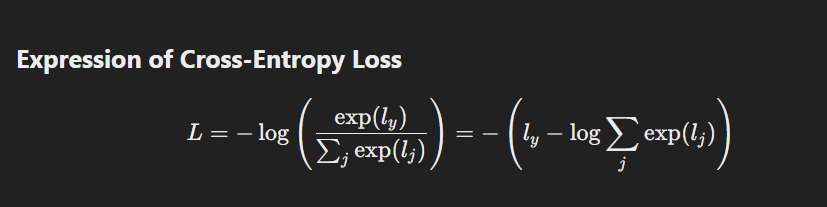

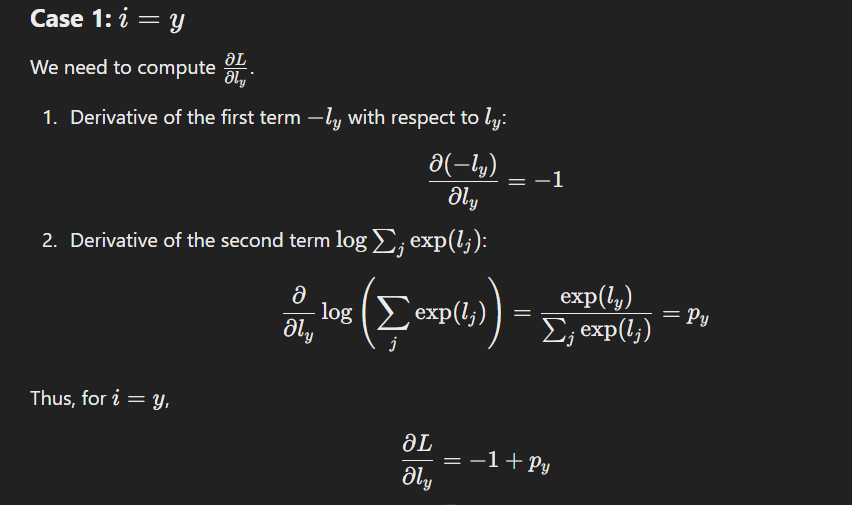

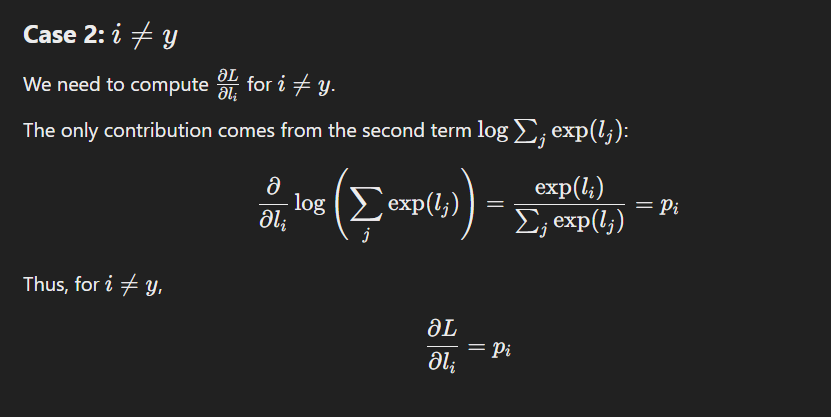

In [ ]:
# backprop through cross_entropy but all in one go
# look at the mathematical expression of the loss,
# take the derivative, simplify the expression, and just write it out

# forward pass

# before:
# logit_maxes = logits.max(1, keepdim=True).values
# norm_logits = logits - logit_maxes # subtract max for numerical stability
# counts = norm_logits.exp()
# counts_sum = counts.sum(1, keepdims=True)
# counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
# probs = counts * counts_sum_inv
# logprobs = probs.log()
# loss = -logprobs[range(n), Yb].mean()

# now:
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff:', (loss_fast - loss).item())

3.337700128555298 diff: 2.384185791015625e-07


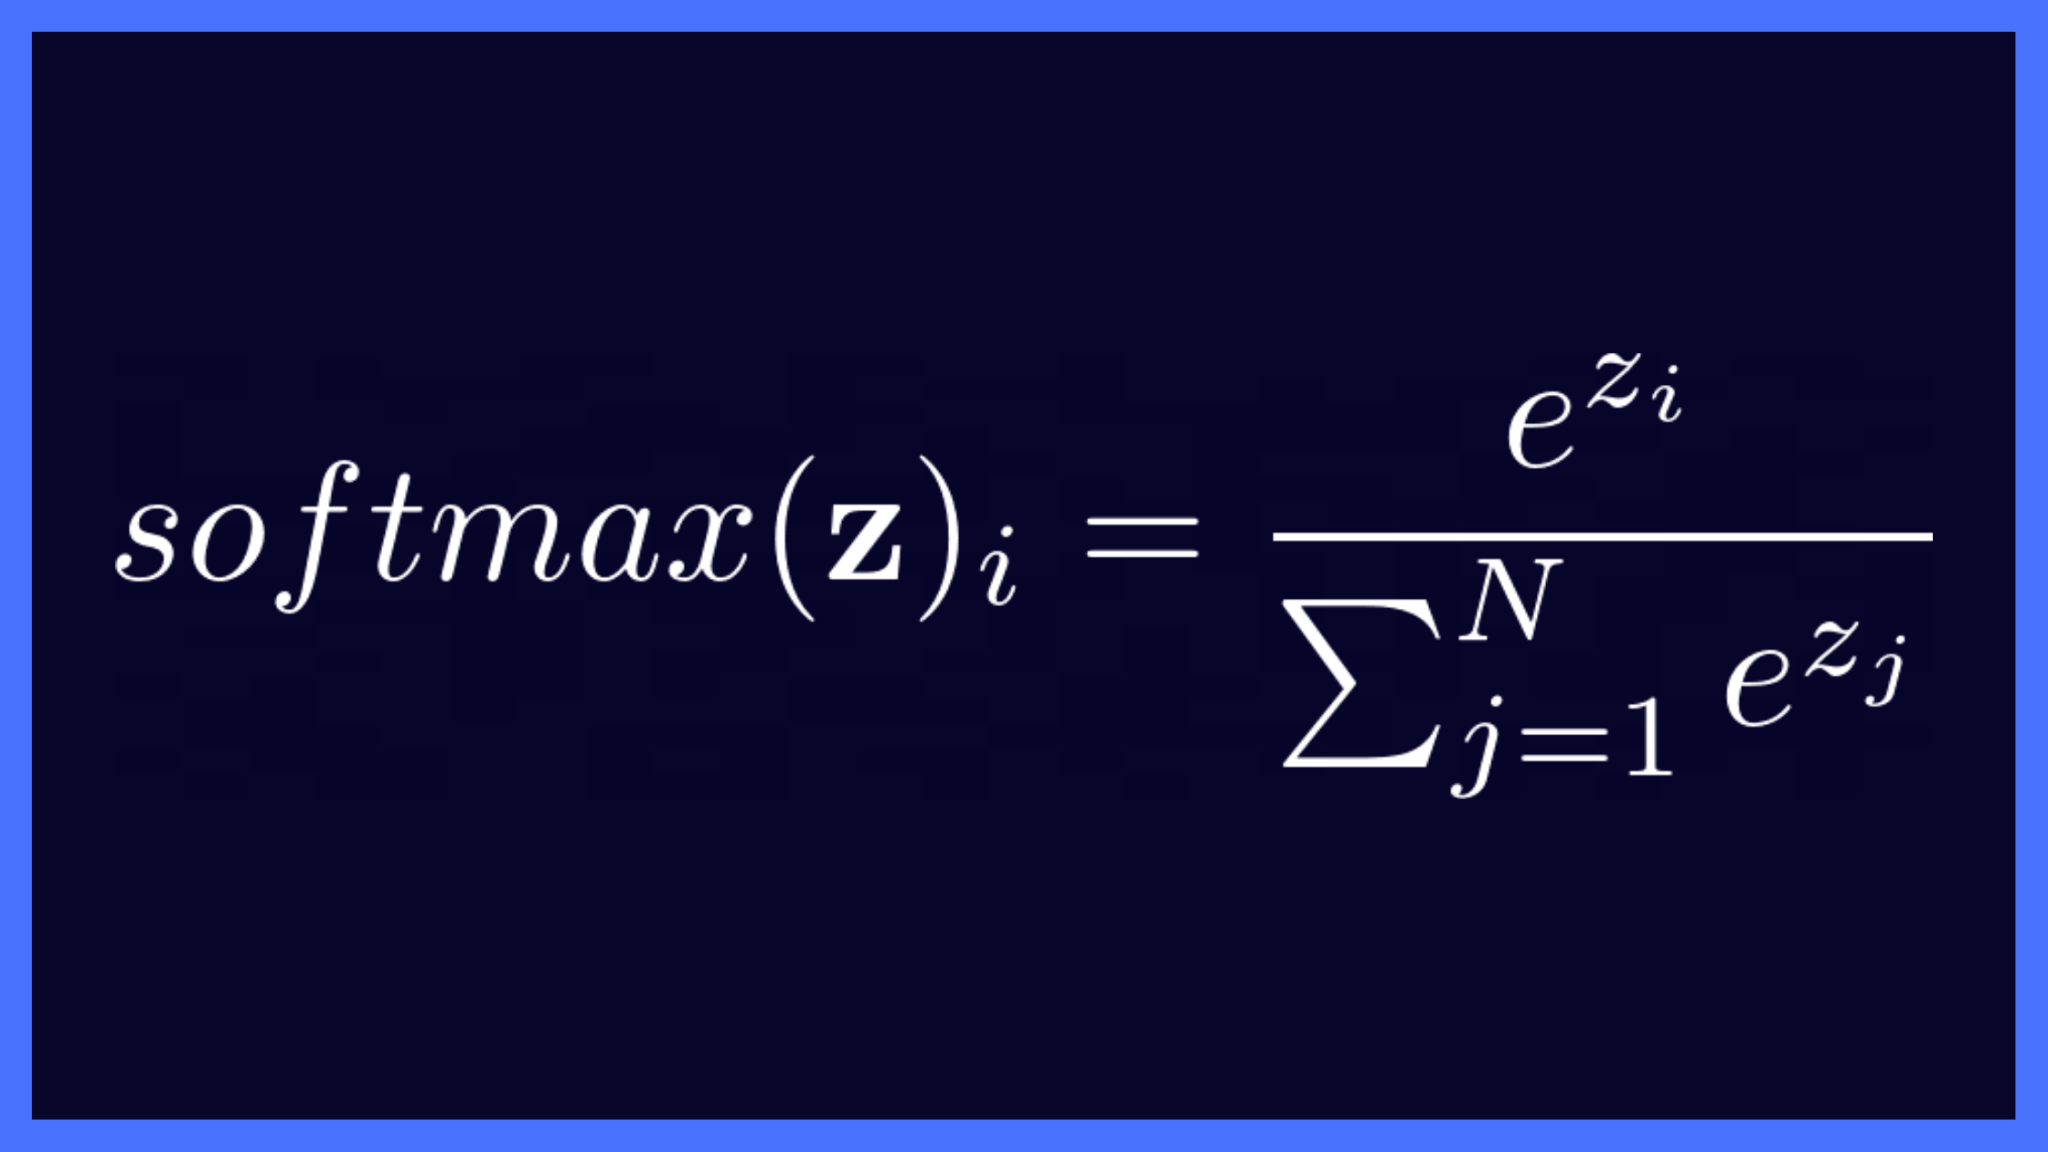

First, we use softmax as pi"the output of derivative" and we applied it to the logits using F.softmax(logits, 1), which converts the raw logits into probabilities by normalizing the exponential of each logit over the sum of exponentials for each sample. This corresponds to calculating the probability distribution from the logits.

Next, the expression dlogits[range(n), Yb] -= 1 adjusts the probabilities for the correct class by subtracting 1. This operation reflects the gradient for the case when i=y(where the derivative becomes pi−1), while the remaining probabilities retain their gradients as pi​ when i≠yi . This compactly handles the two cases discussed in the derivative derivation.

Finally, the gradient values are averaged across the batch by dividing by the batch size nnn using dlogits /= n. This normalization ensures that the loss gradient is appropriately scaled for batch processing, aligning with the loss averaging typically done during training. This approach efficiently computes the gradient for backpropagation in a computationally efficient and numerically stable manner.

In [ ]:
# backward pass

dlogits = F.softmax(logits, 1)
dlogits[range(n), Yb] -= 1
dlogits /= n # to find the mean of the batch

cmp('logits', dlogits, logits)


logits          | exact: False | approximate: True  | maxdiff: 6.05359673500061e-09


### what is dlogits ?

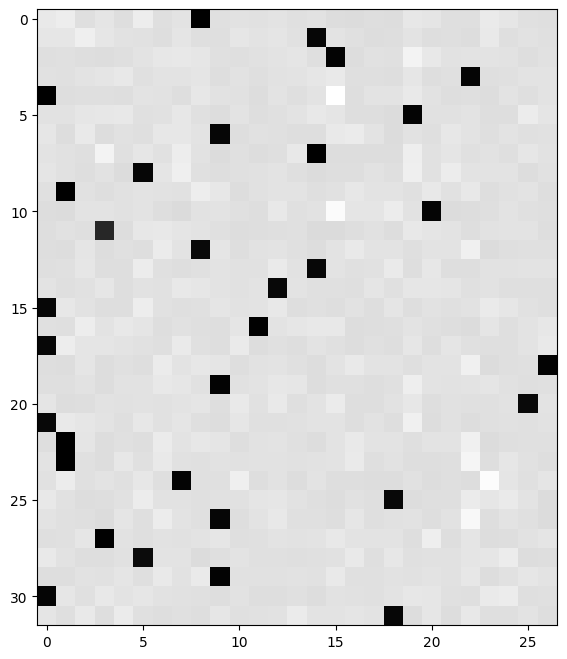

In [ ]:
# what is dlogits ?
plt.figure(figsize=(8,8))
plt.imshow(dlogits.detach() , cmap='gray')
plt.show()

The dlogits variable represents the gradient of the loss with respect to the logits from the forward pass. It essentially captures how much each logit (before the softmax activation) needs to be adjusted to reduce the loss. In other words, it holds the sensitivity of the loss to changes in each logit value.

### **Interpreting the Plot**

1.  **Color Scheme:**Since the plot uses a grayscale colormap (cmap='gray'), lighter shades indicate higher positive values, and darker shades indicate lower (or potentially negative) values.
    
2.  **Axes:**The x-axis represents the different class logits for each sample, and the y-axis represents the individual samples in the batch.
    
3.  **Observation:**
    
    *   We see noticeable gradient intensity around the correct class positions due to the subtraction operation (dlogits\[range(n), Yb\] -= 1).
        
    *   The correct class gradients  appear darker and distinct from other class gradients since the backpropagation reduces their contribution to the loss.
    *    So speaking of the correct label gradient , we got approximately -1 , by increasing its probability , we will reduce the loss , but the other labels are positive "sum = 0" , increasing their probabilities means increasing the loss , so it is a push story -up and down

By the way , the amount you forward probability is incorrect , is the amount we will get the push/pull in the gradient to reduce the loss

In [ ]:
dlogits[0]*n

tensor([ 0.0693,  0.0866,  0.0207,  0.0475,  0.0201,  0.0852,  0.0236,  0.0387,
        -0.9811,  0.0282,  0.0373,  0.0331,  0.0392,  0.0290,  0.0342,  0.0142,
         0.0087,  0.0177,  0.0152,  0.0580,  0.0500,  0.0224,  0.0247,  0.0714,
         0.0556,  0.0270,  0.0234], grad_fn=<MulBackward0>)

In [ ]:
dlogits[0].sum()

tensor(-3.7253e-09, grad_fn=<SumBackward0>)

# We do the same for Batch norm :

In [ ]:
# backprop through batchnorm but all in one go
# look at the mathematical expression of the output of batchnorm,
# take the derivative w.r.t. its input, simplify the expression, and just write it out


# forward pass

# before:
# bnmeani = 1/n*hprebn.sum(0, keepdim=True)
# bndiff = hprebn - bnmeani
# bndiff2 = bndiff**2
# bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
# bnvar_inv = (bnvar + 1e-5)**-0.5
# bnraw = bndiff * bnvar_inv
# hpreact = bngain * bnraw + bnbias

# now:
hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim=True)) / torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True) + 1e-5) + bnbias
print('max diff:', (hpreact_fast - hpreact).abs().max())

max diff: tensor(4.7684e-07, grad_fn=<MaxBackward1>)


By some handy math , we got the final formula


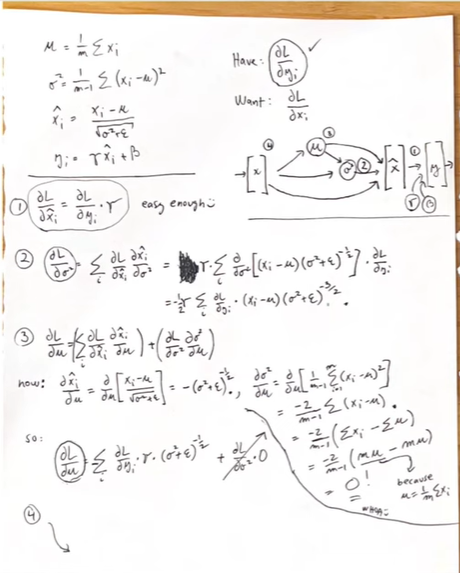

the sum in some components is necessary , don't forget that we are dealing with batches , for exapmle when we try to find the influence of sigma , we have to find the its influence for each x"hat"

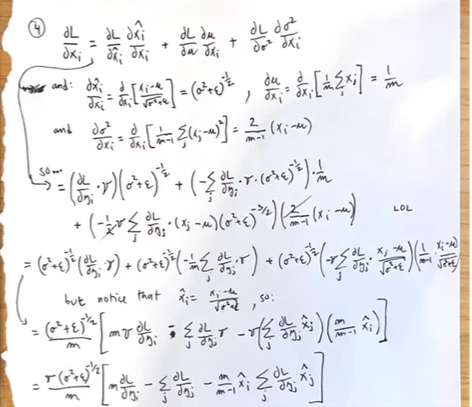

the final components of our final formula , we already define them before like bnvar_inv , bngain ...ect

In [ ]:
# backward pass

# before we had:
# dbnraw = bngain * dhpreact
# dbndiff = bnvar_inv * dbnraw
# dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
# dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
# dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar
# dbndiff += (2*bndiff) * dbndiff2
# dhprebn = dbndiff.clone()
# dbnmeani = (-dbndiff).sum(0)
# dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbnmeani)

# calculating dhprebn given dhpreact (i.e. backprop through the batchnorm)


dhprebn = bngain * bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))

cmp('hprebn', dhprebn, hprebn) # I can only get approximate to be true, my maxdiff is 9e-10

hprebn          | exact: False | approximate: True  | maxdiff: 9.313225746154785e-10


# putting it all together!

## Testing pytorch losses with ours then implementing the network with only our backward

In [ ]:
# putting it all together!
# Train the MLP neural net with your own backward pass

# init
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

# same optimization as last time
max_steps = 200000
batch_size = 32
n = batch_size # convenience
lossi = []

# use this context manager for efficiency once your backward pass is written (TODO)
# with torch.no_grad():

# kick off optimization
for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hprebn = embcat @ W1 + b1 # hidden layer pre-activation
  # BatchNorm layer
  # -------------------------------------------------------------
  bnmean = hprebn.mean(0, keepdim=True)
  bnvar = hprebn.var(0, keepdim=True, unbiased=True)
  bnvar_inv = (bnvar + 1e-5)**-0.5
  bnraw = (hprebn - bnmean) * bnvar_inv
  hpreact = bngain * bnraw + bnbias
  # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward() # use this for correctness comparisons, delete it later!

  # manual backprop! #swole_doge_meme
  # -----------------
  dlogits = F.softmax(logits, 1)
  dlogits[range(n), Yb] -= 1
  dlogits /= n
  # 2nd layer backprop
  dh = dlogits @ W2.T
  dW2 = h.T @ dlogits
  db2 = dlogits.sum(0)
  # tanh
  dhpreact = (1.0 - h**2) * dh
  # batchnorm backprop
  dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
  dbnbias = dhpreact.sum(0, keepdim=True)
  dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))
  # 1st layer
  dembcat = dhprebn @ W1.T
  dW1 = embcat.T @ dhprebn
  db1 = dhprebn.sum(0)
  # embedding
  demb = dembcat.view(emb.shape)
  dC = torch.zeros_like(C)
  for k in range(Xb.shape[0]):
    for j in range(Xb.shape[1]):
      ix = Xb[k,j]
      dC[ix] += demb[k,j]
  grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]
  # -----------------

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p, grad in zip(parameters, grads):

    p.data += -lr * p.grad # old way of cheems doge (using PyTorch grad from .backward())
    #p.data += -lr * grad # new way of swole doge TODO: enable

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

  if i >= 100: # TODO: delete early breaking when you're ready to train the full net
    break

12297
      0/ 200000: 3.7642


In [ ]:
# useful for checking your gradients
for p,g in zip(parameters, grads):
  cmp(str(tuple(p.shape)), g, p)

(27, 10)        | exact: False | approximate: True  | maxdiff: 2.0489096641540527e-08
(30, 200)       | exact: False | approximate: True  | maxdiff: 5.587935447692871e-09
(200,)          | exact: False | approximate: True  | maxdiff: 4.6566128730773926e-09
(200, 27)       | exact: False | approximate: True  | maxdiff: 1.4901161193847656e-08
(27,)           | exact: False | approximate: True  | maxdiff: 7.450580596923828e-09
(1, 200)        | exact: False | approximate: True  | maxdiff: 3.725290298461914e-09
(1, 200)        | exact: False | approximate: True  | maxdiff: 3.725290298461914e-09


## Training the MLP neural net with our backward pass

In [ ]:
# putting it all together!
# Train the MLP neural net with your own backward pass

# init
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

# same optimization as last time
max_steps = 200000
batch_size = 32
n = batch_size # convenience
lossi = []

# use this context manager for efficiency once your backward pass is written (TODO)
with torch.no_grad():


# kick off optimization
  for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Linear layer
    hprebn = embcat @ W1 + b1 # hidden layer pre-activation
    # BatchNorm layer
    # -------------------------------------------------------------
    bnmean = hprebn.mean(0, keepdim=True)
    bnvar = hprebn.var(0, keepdim=True, unbiased=True)
    bnvar_inv = (bnvar + 1e-5)**-0.5
    bnraw = (hprebn - bnmean) * bnvar_inv
    hpreact = bngain * bnraw + bnbias
    # -------------------------------------------------------------
    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
      p.grad = None
    # loss.backward() # use this for correctness comparisons, delete it later!

    # manual backprop! #swole_doge_meme
    # -----------------
    dlogits = F.softmax(logits, 1)
    dlogits[range(n), Yb] -= 1
    dlogits /= n
    # 2nd layer backprop
    dh = dlogits @ W2.T
    dW2 = h.T @ dlogits
    db2 = dlogits.sum(0)
    # tanh
    dhpreact = (1.0 - h**2) * dh
    # batchnorm backprop
    dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
    dbnbias = dhpreact.sum(0, keepdim=True)
    dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))
    # 1st layer
    dembcat = dhprebn @ W1.T
    dW1 = embcat.T @ dhprebn
    db1 = dhprebn.sum(0)
    # embedding
    demb = dembcat.view(emb.shape)
    dC = torch.zeros_like(C)
    for k in range(Xb.shape[0]):
      for j in range(Xb.shape[1]):
        ix = Xb[k,j]
        dC[ix] += demb[k,j]
    grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]
    # -----------------

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p, grad in zip(parameters, grads):

      # p.data += -lr * p.grad # old way of cheems doge (using PyTorch grad from .backward())
      p.data += -lr * grad # new way of swole doge TODO: enable

    # track stats
    if i % 10000 == 0: # print every once in a while
      print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    # if i >= 100: # TODO: delete early breaking when you're ready to train the full net
    #   break

12297
      0/ 200000: 3.8036
  10000/ 200000: 2.1841
  20000/ 200000: 2.3677
  30000/ 200000: 2.4330
  40000/ 200000: 2.0361
  50000/ 200000: 2.3389
  60000/ 200000: 2.3728
  70000/ 200000: 1.9891
  80000/ 200000: 2.4065
  90000/ 200000: 2.1696
 100000/ 200000: 1.9337
 110000/ 200000: 2.2809
 120000/ 200000: 2.0098
 130000/ 200000: 2.5092
 140000/ 200000: 2.1831
 150000/ 200000: 2.2207
 160000/ 200000: 2.0039
 170000/ 200000: 1.8688
 180000/ 200000: 2.0208
 190000/ 200000: 1.9083


In [ ]:
# Calibrating for inference
with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnvar = hpreact.var(0, keepdim=True, unbiased=True)

In [ ]:
# evaluate train and val loss

@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.070390224456787
val 2.109318971633911


In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # ------------
      # forward pass:
      # Embedding
      emb = C[torch.tensor([context])] # (1,block_size,d)
      embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
      hpreact = embcat @ W1 + b1
      hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
      h = torch.tanh(hpreact) # (N, n_hidden)
      logits = h @ W2 + b2 # (N, vocab_size)
      # ------------
      # Sample
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

mora.
mayah.
see.
madhayla.
reisha.
ejdraege.
dered.
elin.
shi.
jenleigh.
sana.
arleigh.
malaia.
noshubergiaghiel.
kinde.
jennex.
terofkusten.
dariyah.
fael.
yuma.
